In [23]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.backend import int_shape, mean,square,random_normal
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import plot_model

In [5]:
(x_train,_),(x_test,_) = mnist.load_data()

In [9]:
size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,size,size,1])
x_test = np.reshape(x_test,[-1,size,size,1])

In [11]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [12]:
# Building the network

# Network Parameters
input_shape = (size,size,1)
batch_size = 32
kernel_size = 3
latent_dim = 16

layers = [32,64]

In [30]:
# Encoder Network
input_layer = Input(shape=input_shape,name='input_encoder_layer')
x = input_layer

for li in layers:
    conv_layer = Conv2D(filters=li,
               kernel_size=kernel_size,
               strides = 2,
               padding='same',
               name = 'encoder_conv_2d_layer'+str(li))
    x = conv_layer(x)
    x = LeakyReLU()(x)

    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.25)(x)

shape = int_shape(x)

x = Flatten()(x)
z_dim = Dense(latent_dim,name='latent_vector')(x)

encoder = Model(input_layer,z_dim,name='Encoder_Network')

In [29]:
print(shape)
dense_shape = shape[1]*shape[2]*shape[3]
print(dense_shape)

(None, 7, 7, 64)
3136


In [31]:
encoder.summary()

Model: "Encoder_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder_layer (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 encoder_conv_2d_layer32 (Co  (None, 14, 14, 32)       320       
 nv2D)                                                           
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 encoder_conv_2d_layer64 (Co  (None, 7, 7, 64)         18496     
 nv2D)                                                           
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                   

In [33]:
# Decoder Network
latent_input_layer = Input(shape = (latent_dim,), name='decoder_input_layer')

x = Dense((dense_shape))(latent_input_layer)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for li in layers[::-1]:
    conv_transpose_layer = Conv2DTranspose(filters=li,
                                           kernel_size=kernel_size,
                                           strides=2,
                                           padding='same',
                                           name='decoder_conv_t_layer'+str(li))
    x = conv_transpose_layer(x)
    x = LeakyReLU()(x)

output_layer = Conv2DTranspose(filters=1,
                               kernel_size=kernel_size, padding='same',activation='sigmoid',name='decoder_output')(x)

decoder = Model(latent_input_layer,output_layer,name='decoder')



In [34]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (InputL  [(None, 16)]             0         
 ayer)                                                           
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_layer64 (Con  (None, 14, 14, 64)       36928     
 v2DTranspose)                                                   
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 decoder_conv_t_layer32 (Con  (None, 28, 28, 32)       1846

In [35]:
# Autoencoder Model
autoencoder = Model(input_layer,decoder(encoder(input_layer)))

In [36]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder_layer (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 Encoder_Network (Functional  (None, 16)               69008     
 )                                                               
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [37]:
opt = Adam(learning_rate=0.001)
autoencoder.compile(loss='mse',optimizer=opt)

In [38]:
autoencoder.fit(x_train,x_train,
                batch_size=32,
                validation_data=(x_test,x_test),
                epochs=10)

Epoch 1/10
1875/1875 [==============================] - 24s 8ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 4/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 10/10
1875/1875 [==============================] - 19s 10ms/s

In [39]:
x_hat = autoencoder.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [41]:
images = np.concatenate([x_test[:8],x_hat[:8]])
images = images.reshape([4,4,size,size])

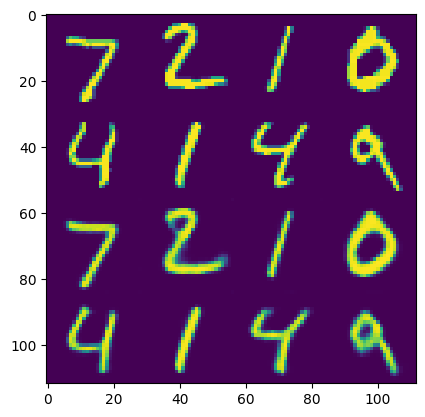

In [44]:
plt.imshow(np.vstack([np.hstack(i) for i in images]))